<a href="https://colab.research.google.com/github/varaiitj2527/PRMLProject/blob/main/FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
from skimage.feature import hog
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [18]:
def ShowImage(img) :

    plt.imshow(img)
    plt.show()

In [6]:
def unpickle(file) :

    dictionary = pickle.load(file, encoding='bytes')
    return dictionary

In [7]:
def load_cifar_batch(filename) :

    '''
      unpickling the file and loading the data in the correct format
      returns features which are pixels,
      labels of a data(images) present in the batchfile

    '''

    with open(filename, 'rb') as file:
        batch_data = unpickle(file)

    pixels = batch_data[b'data']
    labels = batch_data[b'labels']

    # 3072---->3,32,32---->32,32,3
    pixels = pixels.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return pixels, labels

In [8]:
def load_cifar_data() :

    '''
      loading the data from the batch files
      Combining the data from all the batch files train
      returns X_train, y_train, X_test, y_test
    '''

    X_train, y_train = [], []
    for i in range(1, 6):
        pixels, labels = load_cifar_batch(f'data_batch_{i}')
        X_train.append(pixels)
        y_train += labels

    X_train = np.concatenate(X_train)
    y_train = np.array(y_train)

    X_test, y_test = load_cifar_batch('test_batch')
    X_test, y_test = np.array(X_test), np.array(y_test)

    print(f"shape of train set: {X_train.shape}")
    print(f"shape of test set: {X_test.shape}")

    return X_train, y_train, X_test, y_test

In [9]:
X_train, y_train, X_test, y_test = load_cifar_data()

shape of train set: (50000, 32, 32, 3)
shape of test set: (10000, 32, 32, 3)


In [10]:
def create_pickles(path, data) :

    with open(path, 'wb') as f:
        pickle.dump(data, f)

In [11]:
create_pickles('RawPixels_train.pkl', X_train)
create_pickles('Labels_train.pkl', y_train)
create_pickles('RawPixels_test.pkl', X_test)
create_pickles('Labels_test.pkl', y_test)

In [88]:
def compute_HoG(img) :

    '''
      Extracting HoG features
    '''
    HoG_features, HoG_image = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return HoG_features,HoG_image

In [90]:
def HoG_features(data) :

    X_HoG = []
    X_HoG_image = []

    for i in tqdm(range(len(data))) :

        X,Y = compute_HoG(data[i])
        X_HoG.append(X)
        X_HoG_image.append(Y)

    X_HoG = np.array(X_HoG)
    X_HoG_image = np.array(X_HoG_image)

    return X_HoG,X_HoG_image

In [92]:
train_features_HoG, train_images_HoG = HoG_features(X_train)
create_pickles('TrainFeaturesHoG.pkl', train_features_HoG)

100%|██████████| 50000/50000 [02:50<00:00, 293.30it/s]


In [93]:
print(train_features_HoG.shape)

(50000, 324)


In [94]:
test_features_HoG, test_images_HoG = HoG_features(X_test)
create_pickles('TestFeaturesHoG.pkl', test_features_HoG)

100%|██████████| 10000/10000 [00:33<00:00, 301.85it/s]


Using PCA modifying the features such that resulting number of components are chosenwhen they have high variances (around 99)

In [23]:
'''
  flattening the pixels RGB to single array and then applying PCA
'''
height,width,color = X_train.shape[1:4]
X_train_flatten = X_train.reshape(-1, height * width * color)
X_test_flatten = X_test.reshape(-1, height * width * color)

pca = PCA(0.99)
pca.fit(X_train_flatten)
PCA(copy = True, iterated_power = 'auto', n_components = 0.99, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = False)

best_number_of_components = pca.n_components_

In [24]:
print(best_number_of_components)

658


In [49]:
pca = PCA(best_number_of_components)
X_train_PCA = pca.fit_transform(X_train_flatten)
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_test_PCA = pca.transform(X_test_flatten)
X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)

In [50]:
def DeNormalize_Image(image) :

    image = (image - image.min())/(image.max() - image.min())
    image *= 255
    return image.astype(np.uint8)

In [97]:
create_pickles('TrainFeaturesPCA.pkl', X_train_PCA)
create_pickles('TestFeaturesPCA.pkl', X_test_PCA)

In [99]:
HoG_pca = PCA(0.99)
HoG_pca.fit(train_features_HoG)
PCA(copy = True, iterated_power = 'auto', n_components = 0.99, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = False)
best_number_of_components_HoG_pca = HoG_pca.n_components_

In [100]:
print(best_number_of_components_HoG_pca)

170


In [101]:
pca = PCA(best_number_of_components_HoG_pca)
train_features_HoG_pca = pca.fit_transform(train_features_HoG)
test_features_HoG_pca = pca.transform(test_features_HoG)

In [102]:
create_pickles('TrainFeaturesHoG_PCA.pkl', train_features_HoG_pca)
create_pickles('TestFeaturesHoG_PCA.pkl', test_features_HoG_pca)

In [103]:
X_train_approx = X_train_PCA_inverse.reshape(-1,32,32,3)
X_test_approx = X_test_PCA_inverse.reshape(-1,32,32,3)

for image in X_train_approx :
  image = DeNormalize_Image(image)

for image in X_test_approx :
  image = DeNormalize_Image(image)

X_train_approx = X_train_approx.astype(np.uint8)
X_test_approx = X_test_approx.astype(np.uint8)

In [104]:
print(X_train_approx.shape)
print(X_test_approx.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [105]:
print(X_train_approx.dtype)

uint8


In [106]:
X_train_PCA_HoG,X_train_PCA_HoG_images = HoG_features(X_train_approx)
X_test_PCA_HoG,X_test_PCA_HoG_images = HoG_features(X_test_approx)

100%|██████████| 10000/10000 [00:33<00:00, 300.78it/s]


In [107]:
create_pickles('TrainFeaturesPCA_HoG.pkl', X_train_PCA_HoG)
create_pickles('TestFeaturesPCA_HoG.pkl', X_test_PCA_HoG)

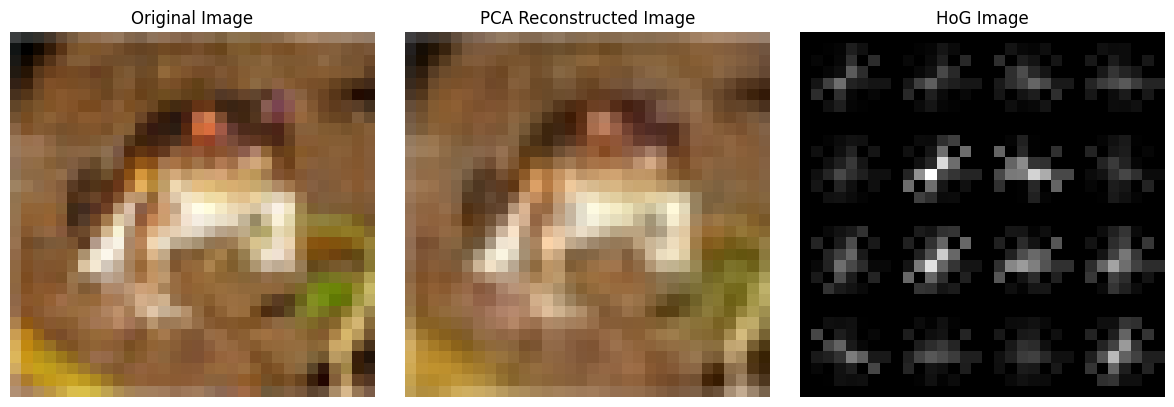

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X_train[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(DeNormalize_Image(X_train_PCA_inverse[0].reshape(32, 32, 3)))
axes[1].set_title('PCA Reconstructed Image')
axes[1].axis('off')

axes[2].imshow(train_images_HoG[0], cmap='gray')
axes[2].set_title('HoG Image')
axes[2].axis('off')

plt.tight_layout()